<h1><center>DS420 - Lab4: Tree Methods

## Introduction

You've been hired by a pet food company to try to predict why some batches of their pet food are spoiling much quicker than intended! Unfortunately this pet food company hasn't upgraded to the latest machinery, meaning that the amounts of the five preservative chemicals they are using can vary a lot, but which is the chemical that has the strongest effect? The company first mixes up a batch of preservative that contains 4 different preservative chemicals (A,B,C,D) and then is completed with a "filler" chemical. The food scientists believe one of the A, B, C or D preservatives is causing the problem, but need your help to figure out which one!

Use Spark Machine Learning methods to find out which parameter had the most predictive power, thus finding out which chemical causes the early spoiling! So create a model and then find out how you can decide which chemical is the problem!

* Pres_A : Percentage of preservative A in the mix
* Pres_B : Percentage of preservative B in the mix
* Pres_C : Percentage of preservative C in the mix
* Pres_D : Percentage of preservative D in the mix
* Spoiled: Label indicating whether or not the dog food batch was spoiled.

## Q1 (10 points): Environment Setup and Data Loading

#### Setup Spark path.

In [1]:

import findspark

findspark.init('/opt/spark')
from pyspark.sql import SparkSession



#### Create a spark session named as "lab4_xxx", where xxx is your last name.

In [84]:

spark = SparkSession.builder.appName('lab4_moynihan').getOrCreate()


#### Load the dataset into a DataFrame named as `data`.

In [219]:
# Load and parse the data file, converting it to a DataFrame.
from pyspark import SparkFiles

url = 'https://raw.githubusercontent.com/BlueJayADAL/DS420/master/datasets/lab4/lab4.csv'







In [220]:
spark.sparkContext.addFile(url)
fileloc = SparkFiles.get('lab4.csv')
data = spark.read.csv('file://'+fileloc, inferSchema=True, header=True)


#### Show the schema of the DataFrame

In [221]:
data.printSchema()



root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



#### Show the first row in the `Row` data format.

In [222]:
data.head()

Row(A=4, B=2, C=12.0, D=3, Spoiled=1.0)

#### Show the basic statistics of the DataFrame. See if the feature columns need to be standardized.

In [223]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|                 A|                 B|                 C|                 D|            Spoiled|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               490|               490|               490|               490|                490|
|   mean|  5.53469387755102| 5.504081632653061| 9.126530612244897| 5.579591836734694| 0.2857142857142857|
| stddev|2.9515204234399057|2.8537966089662063|2.0555451971054275|2.8548369309982857|0.45221563164613465|
|    min|                 1|                 1|               5.0|                 1|                0.0|
|    max|                10|                10|              14.0|                10|                1.0|
+-------+------------------+------------------+------------------+------------------+-------------------+



## Q2 (15 points): EDA

#### Convert the Spark DataFrame into a Pandas DataFrame

In [224]:
df = data.toPandas()



In [225]:
# Show the top 5 records from the Pandas DataFrame

df.head(5)


,A,B,C,D,Spoiled
0,4,2,12.0,3,1.0
1,5,6,12.0,7,1.0
2,6,2,13.0,6,1.0
3,4,2,12.0,1,1.0
4,4,2,12.0,3,1.0


#### Show the value distribution for all feature columns in a subplot.

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

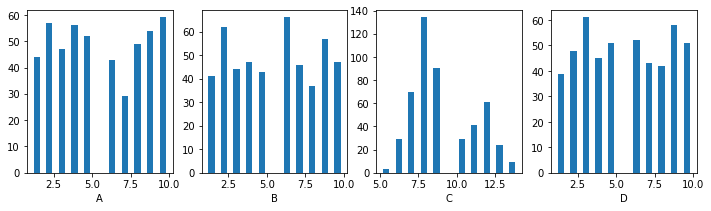

In [227]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize = (12, 3))

for i in range(len(axs)):
    axs[i].set_xlabel(df.columns[i])
    # TODO: Plot the histogram for every axis
    axs[i].hist(df[df.columns[i]], 11, rwidth=0.5)
    

#### Show the counts of the labels. Looks like we got some imbalanced data

In [228]:
import seaborn as sns

/home/lip/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Spoiled', ylabel='count'>

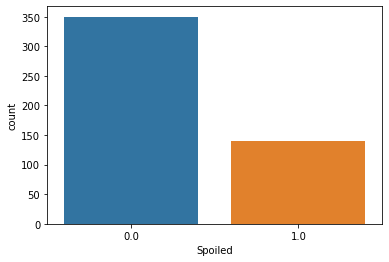

In [229]:
sns.countplot(df['Spoiled'])

#### Show a heapmap of the Pearson's correlation among all columns. What can you observe?

<AxesSubplot:>

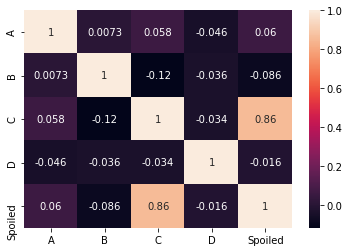

In [230]:
sns.heatmap(df.corr(), annot=True)

## Q3 (15 points): Data Preparation

#### Generate the `features` column

In [231]:
# Import VectorAssembler 

from pyspark.ml.feature import VectorAssembler


In [232]:
df.columns

Index(['A', 'B', 'C', 'D', 'Spoiled'], dtype='object')

In [233]:
# Create VectorAssembler object
assembler =  VectorAssembler(inputCols=['A', 'B', 'C', 'D'],
                           outputCol ='features')



In [234]:
# Transform the data
data = assembler.transform(data)



In [235]:
data.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)
 |-- features: vector (nullable = true)



#### Standardize the data with StandardScaler ([reference](https://spark.apache.org/docs/latest/ml-features.html#standardscaler)).

In [236]:
# Import StandardScaler

from pyspark.ml.feature import StandardScaler

In [237]:
# Create scaler object
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)


In [238]:
# Transform the data with the scaler
scaledData = scaler.fit(data).transform(data)



In [239]:
scaledData.show()

+---+---+----+---+-------+-------------------+--------------------+
|  A|  B|   C|  D|Spoiled|           features|      scaledFeatures|
+---+---+----+---+-------+-------------------+--------------------+
|  4|  2|12.0|  3|    1.0| [4.0,2.0,12.0,3.0]|[1.35523371894480...|
|  5|  6|12.0|  7|    1.0| [5.0,6.0,12.0,7.0]|[1.69404214868100...|
|  6|  2|13.0|  6|    1.0| [6.0,2.0,13.0,6.0]|[2.03285057841720...|
|  4|  2|12.0|  1|    1.0| [4.0,2.0,12.0,1.0]|[1.35523371894480...|
|  4|  2|12.0|  3|    1.0| [4.0,2.0,12.0,3.0]|[1.35523371894480...|
| 10|  3|13.0|  9|    1.0|[10.0,3.0,13.0,9.0]|[3.38808429736200...|
|  8|  5|14.0|  5|    1.0| [8.0,5.0,14.0,5.0]|[2.71046743788960...|
|  5|  8|12.0|  8|    1.0| [5.0,8.0,12.0,8.0]|[1.69404214868100...|
|  6|  5|12.0|  9|    1.0| [6.0,5.0,12.0,9.0]|[2.03285057841720...|
|  3|  3|12.0|  1|    1.0| [3.0,3.0,12.0,1.0]|[1.01642528920860...|
|  9|  8|11.0|  3|    1.0| [9.0,8.0,11.0,3.0]|[3.04927586762580...|
|  1| 10|12.0|  3|    1.0|[1.0,10.0,12.0,3.0]|[0

## Q4 (20 points): Fix data imbalance with oversampling. 

#### Step1: calculate the ratio of label `0.0` to label `1.0`

In [240]:
import pyspark.sql.functions as F


In [241]:
count_zeros = data.select('Spoiled').where(data.Spoiled==0.0).count()
count_ones  =data.select('Spoiled').where(data.Spoiled==1.0).count()


# Ratio of zero to one
ratio = count_zeros / count_ones
print("Ratio of zero to one:", ratio)

Ratio of zero to one: 2.5


#### Step2: Double the minority group by oversampling 100% more data. You may want to use PySpark's `sample()` method ([reference](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.sample.html)). Use seed as 101.

In [242]:
extraOnes = scaledData.filter(scaledData['Spoiled']==1.0).sample(withReplacement=True, fraction=1.0, seed=101)


extraOnes.count()

140

#### Step3: concatenate the original DataFrame `scaledData` with the DataFrame `extraOnes` from step2 using the `unionAll` method. 

In [243]:
combinedData = scaledData.unionAll(extraOnes)
combinedData.count()

630

#### Now, split the data into training and testing. Use ratio of 0.7, and seed of 101.

In [244]:
train_data, test_data =  combinedData.randomSplit([0.7,0.3], seed = 101)



## Q5 (10 points): Training the models

#### Import models: decision tree, random forest, and gradient boosted trees

In [245]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.classification import GBTClassifier

#### Create all three objects out of each classifier with default parameters. Use seed as 101 when needed.

In [248]:
# Use mostly defaults to make this comparison "fair"

dtc = DecisionTreeClassifier(labelCol='Spoiled')

rfc = RandomForestClassifier(labelCol='Spoiled')

gbt = GBTClassifier(labelCol='Spoiled')



#### Train all three models

In [249]:
# Train the models (there are three models, so it might take some time)
dtc_model = dtc.fit(train_data)

rfc_model = rfc.fit(train_data)

gbt_model = gbt.fit(train_data)

## Q6 (10 points): Model Evaluation

#### Let's compare each of these models by firstly generating their predicted results with test data.

In [250]:
dtc_predictions = dtc_model.transform(test_data)

rfc_predictions = rfc_model.transform(test_data)

gbt_predictions = gbt_model.transform(test_data)

#### Evaluate all the model accuracy

In [251]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [252]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol='Spoiled',
                                                 metricName='accuracy')



In [253]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)

rfc_acc = acc_evaluator.evaluate(rfc_predictions)

gbt_acc = acc_evaluator.evaluate(gbt_predictions)


In [254]:
print("Model accuracy:")
print('Decision tree: {0:2.2f}%'.format(dtc_acc*100))
print('Random forest: {0:2.2f}%'.format(rfc_acc*100))
print('GBT: {0:2.2f}%'.format(gbt_acc*100))

Model accuracy:
Decision tree: 96.48%
Random forest: 97.49%
GBT: 96.48%


## Q7 (10 points): Draw a Conclusion

#### You are not done yet on the consulting job with the Pet Food Company - now it's time to report back! Tell them which chemical indeed caused the early spoiling. You need to back up your claim with data. 

You may want to use code as well as statements in markdown to answer this question.

In [262]:
print(dtc_model.featureImportances)
print(rfc_model.featureImportances)
print(gbt_model.featureImportances)

(4,[0,1,2,3],[0.01680952144226968,0.00045904173362641584,0.9656814792328892,0.017049957591214793])
(4,[0,1,2,3],[0.014241681896786073,0.013768661433667905,0.9520982713495411,0.019891385320005055])
(4,[0,1,2,3],[0.03502447594102253,0.023119007061212983,0.887147672902855,0.054708844094909496])


Reasoning: From the models, each model used the '2' chemical was the most important in causing early spoiling. This chemical should be furthered explored. The other chemicals have less than .1 importance and there is a big imbalance in the importances of the chemicals in comparison to chemical '2'



## Q8 (10 points): Improvement and Deployment

#### Now try to use Cross Validation to fine tune your GBT models' parameters and see whether you can squeeze in more accuracy! Report back the optimal parameters.

[Reference to Cross Validator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator)

#### Import the necessary libraries and create the baseline model.

In [266]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel


gbt = GBTClassifier(labelCol='Spoiled')


#### Create the parameter grid for GBT with the following setup:

> ```
maxDepth: 4, 8, 12
maxIter: 10, 30
```

In [267]:
grid = ParamGridBuilder().addGrid(gbt.maxDepth, [4, 8, 12]).addGrid(gbt.maxIter, [10, 30]).build()



#### Create the cross validator object `cv` with the baseline `gbt` model, the parameter grid, the multi-class evaluator we used before, and set the parallelism level to 4 for speedup. Use seed = 101.

In [268]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=acc_evaluator,
    parallelism=4, seed=101)



#### Train the gbt model with the cross validator.

In [270]:
cvModel = cv.fit(train_data)



#### Make predictions with the trained model.

In [271]:
cv_predictions = cvModel.transform(test_data)


#### Print the model accuracy. 

In [272]:
cvModel_acc = acc_evaluator.evaluate(cv_predictions)



In [273]:
print("GBT Accuray: ", cvModel_acc)

GBT Accuray:  0.964824120603015


#### Find the best hyper-parameters from the best model.

In [274]:
cvModel.bestModel.extractParamMap()

{Param(parent='GBTClassifier_23f97f3de0d2', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_23f97f3de0d2', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_23f97f3de0d2', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

# Great Job!